In [1]:
#autoreload 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import lightning as lt
import yaml
from models.CNNAE import AE
import matplotlib.pyplot as plt

ckpt_path = "/home/npopkov/vesuvius_gcml/notebooks/encoder_ckpt/"

encoder_path = ckpt_path + "encoder.pth"
attention_path = ckpt_path + "attention.pth"

aae = AE()
#aae.encoder.load_state_dict(torch.load(encoder_path))
#aae.attention.load_state_dict(torch.load(attention_path))

encoder = aae.encoder
attention = aae.attention



/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
a = torch.randn(16,16, 32, 32)
b = torch.randn(16, 32)
#add all 16 layers of a to b
c = torch.sum(torch.sum(a, dim=1),dim = 2) + b
print(a.shape, b.shape, c.shape)

torch.Size([16, 16, 32, 32]) torch.Size([16, 32]) torch.Size([16, 32])


In [ ]:
from ml.inklabel_dataset import InkLabelDataset
segment_ids = yaml.safe_load(open('../configs/segment_ids.yaml', 'r'))
print(segment_ids['segment_ids'])
segments = segment_ids['segment_ids']['segments']
SAMPLE_SIZE = 128
dataset = InkLabelDataset(segment_ids=segments,sample_size=SAMPLE_SIZE)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_Loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True,num_workers=27)
test_Loader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False,num_workers=27)
validation_Loader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=False,num_workers=27)

{'segments': ['20231210121321', '20231106155350', '20231005123336', '20230820203112', '20230620230619', '20230826170124', '20230702185753', '20230522215721', '20230531193658', '20230520175435', '20230903193206', '20230902141231', '20231007101615', '20230929220924', 'recto', 'verso', '20231016151000', '20231012184423', '20231031143850']}
Creating InkLabelDataset with 19 segments...
Error processing segment verso: invalid literal for int() with base 10: 'verso'Error processing segment recto: invalid literal for int() with base 10: 'recto'

An error occurred while initializing the Volume class: URL not found for scroll: None, energy: None, resolution: None, segment: 20231031143850An error occurred while initializing the Volume class: URL not found for scroll: None, energy: None, resolution: None, segment: 20231012184423

Load the canonical scroll 1 with Volume(type="scroll", scroll_id=1, energy=54, resolution=7.91)Load the canonical scroll 1 with Volume(type="scroll", scroll_id=1, energy=

In [ ]:
trainer = lt.Trainer(max_epochs=500, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


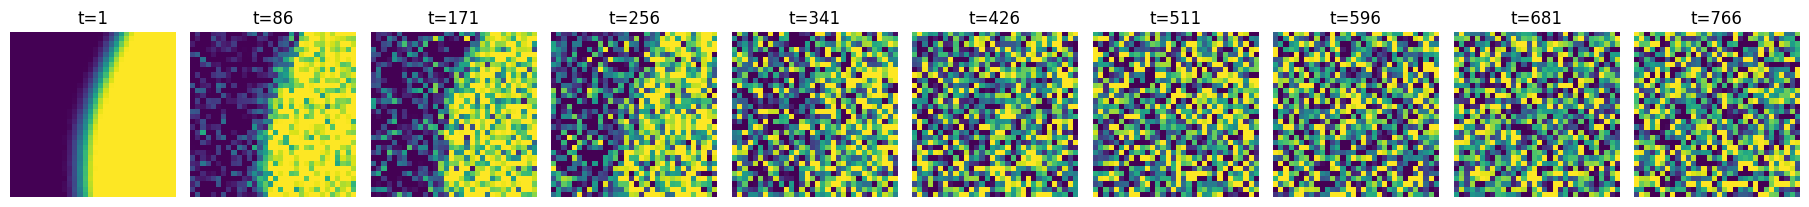

In [ ]:
from models.condDDPM import Diffusion

ddpm = Diffusion(
    noise_steps=850,
    beta_start=1e-4,
    beta_end=0.03,
    img_size=SAMPLE_SIZE,
    c_in=1,
    c_out=1,
    encoder=None,
    attention=None
)

ddpm.plot_test_noising(x=next(iter(train_Loader))['ink_label'][0].float().cuda())

In [ ]:
trainer.fit(ddpm, train_Loader, validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | UNet_conditional | 15.5 M | train
1 | ema_model | UNet_conditional | 15.5 M | eval 
-------------------------------------------------------
15.5 M    Trainable params
15.5 M    Non-trainable params
30.9 M    Total params
123.680   Total estimated model params size (MB)
197       Modules in train mode
197       Modules in eval mode


/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 91/91 [00:06<00:00, 14.51it/s, v_num=43]

/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 91: 100%|██████████| 91/91 [00:08<00:00, 10.77it/s, v_num=43]


In [ ]:
ddpm.save(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt")

In [ ]:
ddpm.load(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt")

Output shape after training: torch.Size([16, 1, 32, 32])


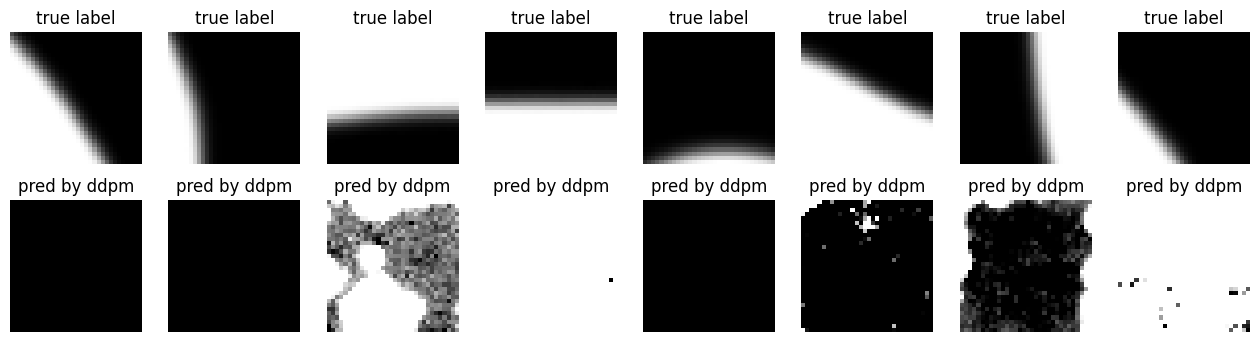

In [ ]:
test_sample = next(iter(test_Loader))

test_results = ddpm.__test_after_training__(test_sample['scroll_segment'].float().cuda())

plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(test_sample['ink_label'][i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("true label")

    plt.subplot(2, 8, i + 9)
    plt.imshow(test_results[i][0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("pred by ddpm")

plt.show()

In [ ]:
print(test_sample['ink_label'][0], test_results[0])

tensor([[  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255],
        ...,
        [  0,   0,   0,  ...,   0,   0,   1],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]], dtype=torch.uint8) tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [125, 126, 127,  ..., 127, 126, 125],
         [127, 127, 126,  ..., 127, 126, 124],
         [127, 125, 127,  ..., 125, 126, 128]]], device='cuda:0',
       dtype=torch.uint8)


In [ ]:
from ml import matching_pixels, matching_pixels_subset_max

res = matching_pixels(test_sample['ink_label'].cpu().numpy()[0],test_results.squeeze().cpu().numpy()[0])
print(res / (32*32))

res = matching_pixels_subset_max(test_sample['ink_label'].cpu().numpy(),test_results.squeeze().cpu().numpy()[0])
print(res / (32*32))

0.2666015625


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 68971.08it/s]

0.5244140625


In [ ]:
res = matching_pixels(test_sample['ink_label'].cpu().numpy()[0],test_sample['ink_label'].cpu().numpy()[0])
res

1024